In [336]:
import pandas as pd 
import numpy as np 
import nltk
import nltk.corpus
from nltk.corpus import words
from nltk.tokenize import WhitespaceTokenizer
import matplotlib.pyplot as plt
import random

from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Preprocessing Dataset

In [337]:
data_path = '/Users/abdoulabdillahi/Desktop/CSC 680/Final_project/chat_slang/data/slang.csv'
df = pd.read_csv(data_path)

In [338]:
df.shape

(3357, 3)

In [339]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,acronym,expansion
0,2day,today
1,2m2h,too much too handle
2,2moro,tomorrow
3,2nite,tonight
4,4eae,for ever and ever


In [340]:
# Generate text with acronyms 
def generate_text_with_acronyms(df, num_sentences=5, num_acronyms_to_use=5):
    sentences = []
    for _ in range(num_sentences):
        sentence = []
        # Randomly choose acronyms and use them in the sentence
        sampled_acronyms = random.sample(range(len(df)), min(num_acronyms_to_use, len(df)))
        for idx in sampled_acronyms:
            acronym, expansion = df.iloc[idx]['acronym'], df.iloc[idx]['expansion']
            # Construct the sentence using the acronym and its expansion
            sentence.append(random.choice([acronym, expansion]))
        sentences.append(" ".join(sentence))
    return " ".join(sentences)

In [341]:
#generate_text_with_acronyms(df, 2,7)

In [342]:
# creating a new column to generate synthetic text 
df['informal_text'] = df.apply( lambda row:generate_text_with_acronyms(df, num_sentences=3, num_acronyms_to_use=5), axis=1)

In [343]:
pd.set_option('display.max_colwidth', 255)

In [344]:
df.head(10)

,acronym,expansion,informal_text
0,2day,today,monday night football bot line of site happy birthday to you nbb now back to work gsm young gangster love you ttotm young lady pmt get your coat multi user omgd
1,2m2h,too much too handle,no one likes you no thank you sorn be back in a sec rd tyb abd agh ttul masters of business association married but available bad game baby gangster pvr g o a t yid vip
2,2moro,tomorrow,if i tell you what this means will you kiss me ays not going to lie rq windows media player with much pleasure heard understood acknowledged ikwym quite laughing how ya doing quod erat demonstrandum itso tell me about it where are you from mgk totb
3,2nite,tonight,annual general meeting ysmtu ohac national association of securities dealers automated quotation hit you up jdi cry me a river hall of fame heavy on flag tyvm before gafm do not want oh never mind law enforcement officer hate my life
4,4eae,for ever and ever,ilylas jj nyi multiple input multiple output good to see you read between the lines thwu hope to see you soon dmta wiyp giggling to myself rsi att wwu mwm
5,aaf,as a friend,ggn as far as i know cwtsy wsic cable news network national health service nr ivf kpi at any rate hr lshmbh have a nice day excellent used condition night night no need not nice
6,aar,at any rate,tfios masters of business association married but available ptmm h2cus gyaldem parents over the shoulder bcnu wtc lfdy state of alert oh never mind adad icu peace be upon him aayf
7,aayf,as always your friend,keep it gangsta ofoc i know huh request for proposal tgft usb god bless you lwwy good night all of day whatever you want amw you win some you lose some rtv no further message
8,abd,already been done,taylor gang or die mind your own business black gangster disciples rtfi htc mainstream media iac tbqf alwp mgmt issn gf afp bust out another thousand hoas
9,ack,acknowledge,sswa wydn up to date before parenthesis exponents multiply divide add subtract tmi big name on campus not safe for anyone very good game cd rw i am not bothered no kidding not known ttte best mates til the very end nft


In [345]:
# Tokenisation
tokenizer = WhitespaceTokenizer()
def tokenise(text):
    return tokenizer.tokenize(str(text))

df['tokenized_text'] = df['informal_text'].apply(lambda x: tokenise(x))

In [346]:
df.head()

,acronym,expansion,informal_text,tokenized_text
0,2day,today,monday night football bot line of site happy birthday to you nbb now back to work gsm young gangster love you ttotm young lady pmt get your coat multi user omgd,"[monday, night, football, bot, line, of, site, happy, birthday, to, you, nbb, now, back, to, work, gsm, young, gangster, love, you, ttotm, young, lady, pmt, get, your, coat, multi, user, omgd]"
1,2m2h,too much too handle,no one likes you no thank you sorn be back in a sec rd tyb abd agh ttul masters of business association married but available bad game baby gangster pvr g o a t yid vip,"[no, one, likes, you, no, thank, you, sorn, be, back, in, a, sec, rd, tyb, abd, agh, ttul, masters, of, business, association, married, but, available, bad, game, baby, gangster, pvr, g, o, a, t, yid, vip]"
2,2moro,tomorrow,if i tell you what this means will you kiss me ays not going to lie rq windows media player with much pleasure heard understood acknowledged ikwym quite laughing how ya doing quod erat demonstrandum itso tell me about it where are you from mgk totb,"[if, i, tell, you, what, this, means, will, you, kiss, me, ays, not, going, to, lie, rq, windows, media, player, with, much, pleasure, heard, understood, acknowledged, ikwym, quite, laughing, how, ya, doing, quod, erat, demonstrandum, itso, tell, me, ..."
3,2nite,tonight,annual general meeting ysmtu ohac national association of securities dealers automated quotation hit you up jdi cry me a river hall of fame heavy on flag tyvm before gafm do not want oh never mind law enforcement officer hate my life,"[annual, general, meeting, ysmtu, ohac, national, association, of, securities, dealers, automated, quotation, hit, you, up, jdi, cry, me, a, river, hall, of, fame, heavy, on, flag, tyvm, before, gafm, do, not, want, oh, never, mind, law, enforcement, ..."
4,4eae,for ever and ever,ilylas jj nyi multiple input multiple output good to see you read between the lines thwu hope to see you soon dmta wiyp giggling to myself rsi att wwu mwm,"[ilylas, jj, nyi, multiple, input, multiple, output, good, to, see, you, read, between, the, lines, thwu, hope, to, see, you, soon, dmta, wiyp, giggling, to, myself, rsi, att, wwu, mwm]"


In [347]:
# Define a replace informal function to formal 
def replace_informal(tokens, informal):
    tokens = [informal.get(token.lower(), token) for token in tokens]
    return ' '.join(tokens)

In [348]:
# apply replace informal function to the
def formalize_dataframe(df, informal):
    df['formal_text'] = df['tokenized_text'].apply(lambda x: replace_informal(x, informal))
    return df

In [349]:
# Mapping dictionnary from acronyms and their expansion 
informal_to_formal = dict(zip(df['acronym'], df['expansion']))

In [350]:
informal_to_formal

{'2day': 'today',
 '2m2h': 'too much too handle',
 '2moro': 'tomorrow',
 '2nite': 'tonight',
 '4eae': 'for ever and ever',
 'aaf': 'always and forever',
 'aar': 'at any rate',
 'aayf': 'as always your friend',
 'abd': 'already been done',
 'ack': 'acknowledge',
 'adih': 'another day in hell',
 'adn': 'any day now',
 'adr': 'all due respect',
 'aeap': 'as early as possible',
 'afaic': 'as far as i am concerned',
 'afaik': 'as far as i know',
 'aka': 'also known as',
 'ama': 'ask me anything against medical advice',
 'ambw': 'all my best wishes',
 'aml': 'all my love',
 'aota': 'all of the above',
 'asap': 'as soon as possible',
 'atb': 'all the best',
 'ateotd': 'at the end of the day',
 'atm': 'at the moment automated teller machine ',
 'awol': 'absent without leave',
 'aydy': 'are you done yet',
 'ayec': 'at your earliest convenience',
 'ayor': 'at your own risk',
 'ays': 'are you serious',
 'aysos': 'are you stupid or something',
 'ayt': 'are you there',
 'b/c': 'because',
 'b4': 'be

In [351]:
df= formalize_dataframe(df, informal_to_formal)

In [352]:
df.head()

,acronym,expansion,informal_text,tokenized_text,formal_text
0,2day,today,monday night football bot line of site happy birthday to you nbb now back to work gsm young gangster love you ttotm young lady pmt get your coat multi user omgd,"[monday, night, football, bot, line, of, site, happy, birthday, to, you, nbb, now, back, to, work, gsm, young, gangster, love, you, ttotm, young, lady, pmt, get, your, coat, multi, user, omgd]",monday night football back on topic line of site happy birthday time out you never been better now back time out work global system for mobile communications young gangster love you that time of the month young lady pre menstrual tension get your coat...
1,2m2h,too much too handle,no one likes you no thank you sorn be back in a sec rd tyb abd agh ttul masters of business association married but available bad game baby gangster pvr g o a t yid vip,"[no, one, likes, you, no, thank, you, sorn, be, back, in, a, sec, rd, tyb, abd, agh, ttul, masters, of, business, association, married, but, available, bad, game, baby, gangster, pvr, g, o, a, t, yid, vip]",no one likes you no thank you statutory off road notification be back in a sec real deal try your best already been done are not going to happen talk to you later masters of business association married but available bad game baby gangster personal vi...
2,2moro,tomorrow,if i tell you what this means will you kiss me ays not going to lie rq windows media player with much pleasure heard understood acknowledged ikwym quite laughing how ya doing quod erat demonstrandum itso tell me about it where are you from mgk totb,"[if, i, tell, you, what, this, means, will, you, kiss, me, ays, not, going, to, lie, rq, windows, media, player, with, much, pleasure, heard, understood, acknowledged, ikwym, quite, laughing, how, ya, doing, quod, erat, demonstrandum, itso, tell, me, ...",if i tell you what this means will you keep it simple stupid me are you serious not going time out lie random questions windows media player where in the hell much pleasure heard understood acknowledged i know what you mean quite laughing how ya doin...
3,2nite,tonight,annual general meeting ysmtu ohac national association of securities dealers automated quotation hit you up jdi cry me a river hall of fame heavy on flag tyvm before gafm do not want oh never mind law enforcement officer hate my life,"[annual, general, meeting, ysmtu, ohac, national, association, of, securities, dealers, automated, quotation, hit, you, up, jdi, cry, me, a, river, hall, of, fame, heavy, on, flag, tyvm, before, gafm, do, not, want, oh, never, mind, law, enforcement, ...",annual general meeting you so made that up own house and car national association of securities dealers automated quotation hit you up just do it cry me a river hall of fame heavy on flag thank you very much before get away from me do not want other h...
4,4eae,for ever and ever,ilylas jj nyi multiple input multiple output good to see you read between the lines thwu hope to see you soon dmta wiyp giggling to myself rsi att wwu mwm,"[ilylas, jj, nyi, multiple, input, multiple, output, good, to, see, you, read, between, the, lines, thwu, hope, to, see, you, soon, dmta, wiyp, giggling, to, myself, rsi, att, wwu, mwm]",i love you like a sister just joking not yet implemented multiple input multiple output good time out see you read between the lines to hell with you hope time out see you soon dirty minds think alike what is your problem giggling time out myself repe...


# Data Transformation and Label Assignment 

In [353]:
# Creating informal dataframe 
informal_df = pd.DataFrame({'Text': df['informal_text'], 'Label': 0})

In [354]:
informal_df.head()

,Text,Label
0,monday night football bot line of site happy birthday to you nbb now back to work gsm young gangster love you ttotm young lady pmt get your coat multi user omgd,0
1,no one likes you no thank you sorn be back in a sec rd tyb abd agh ttul masters of business association married but available bad game baby gangster pvr g o a t yid vip,0
2,if i tell you what this means will you kiss me ays not going to lie rq windows media player with much pleasure heard understood acknowledged ikwym quite laughing how ya doing quod erat demonstrandum itso tell me about it where are you from mgk totb,0
3,annual general meeting ysmtu ohac national association of securities dealers automated quotation hit you up jdi cry me a river hall of fame heavy on flag tyvm before gafm do not want oh never mind law enforcement officer hate my life,0
4,ilylas jj nyi multiple input multiple output good to see you read between the lines thwu hope to see you soon dmta wiyp giggling to myself rsi att wwu mwm,0


In [355]:
formal_df = pd.DataFrame({'Text': df['formal_text'], 'Label':1})

In [356]:
formal_df.head()

,Text,Label
0,monday night football back on topic line of site happy birthday time out you never been better now back time out work global system for mobile communications young gangster love you that time of the month young lady pre menstrual tension get your coat...,1
1,no one likes you no thank you statutory off road notification be back in a sec real deal try your best already been done are not going to happen talk to you later masters of business association married but available bad game baby gangster personal vi...,1
2,if i tell you what this means will you keep it simple stupid me are you serious not going time out lie random questions windows media player where in the hell much pleasure heard understood acknowledged i know what you mean quite laughing how ya doin...,1
3,annual general meeting you so made that up own house and car national association of securities dealers automated quotation hit you up just do it cry me a river hall of fame heavy on flag thank you very much before get away from me do not want other h...,1
4,i love you like a sister just joking not yet implemented multiple input multiple output good time out see you read between the lines to hell with you hope time out see you soon dirty minds think alike what is your problem giggling time out myself repe...,1


In [357]:
# combined the two Dataframe 
combined_df = pd.concat([informal_df, formal_df], ignore_index=True)

In [358]:
combined_df.head()

,Text,Label
0,monday night football bot line of site happy birthday to you nbb now back to work gsm young gangster love you ttotm young lady pmt get your coat multi user omgd,0
1,no one likes you no thank you sorn be back in a sec rd tyb abd agh ttul masters of business association married but available bad game baby gangster pvr g o a t yid vip,0
2,if i tell you what this means will you kiss me ays not going to lie rq windows media player with much pleasure heard understood acknowledged ikwym quite laughing how ya doing quod erat demonstrandum itso tell me about it where are you from mgk totb,0
3,annual general meeting ysmtu ohac national association of securities dealers automated quotation hit you up jdi cry me a river hall of fame heavy on flag tyvm before gafm do not want oh never mind law enforcement officer hate my life,0
4,ilylas jj nyi multiple input multiple output good to see you read between the lines thwu hope to see you soon dmta wiyp giggling to myself rsi att wwu mwm,0


In [359]:
combined_df

,Text,Label
0,monday night football bot line of site happy birthday to you nbb now back to work gsm young gangster love you ttotm young lady pmt get your coat multi user omgd,0
1,no one likes you no thank you sorn be back in a sec rd tyb abd agh ttul masters of business association married but available bad game baby gangster pvr g o a t yid vip,0
2,if i tell you what this means will you kiss me ays not going to lie rq windows media player with much pleasure heard understood acknowledged ikwym quite laughing how ya doing quod erat demonstrandum itso tell me about it where are you from mgk totb,0
3,annual general meeting ysmtu ohac national association of securities dealers automated quotation hit you up jdi cry me a river hall of fame heavy on flag tyvm before gafm do not want oh never mind law enforcement officer hate my life,0
4,ilylas jj nyi multiple input multiple output good to see you read between the lines thwu hope to see you soon dmta wiyp giggling to myself rsi att wwu mwm,0
...,...,...
6709,sense of humor failure joking my eyes glazed over cannot stop laughing what do you want time out talk about i owe you standard attainment tests mash until no good put me down british broadcasting corporation going time out read mail other world kingdo...,1
6710,just always pray at night learn time out google public domain hold on a second parent in the room what shall whatever talk about official use only would like time out meet please leave me alone not okay no one knows no hard feelings live action role p...,1
6711,united states marine corps be gentle where in the hell me get outta my face i know more than you all miss you love mash until no good late laugh loudly lol have a good night why the heck not what do you think big game license likes fat people word of ...,1
6712,lucky win all miss you love oh really national aeronautics and space administration behind closed doors go for information technology hyper text transfer protocol secure just out of curiosity good game no thanks needed i will be back entertainment and...,1


In [360]:
len(combined_df)

6714

In [361]:
# shuffle the DataFrame 
dframe = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [362]:
dframe.head()

,Text,Label
0,if it fits your macros i am outta here mih paid time off vig thanks for the invitation glws i love you to bits aota smiling for real miss you loads tdg i am going now bye wsm jaf,0
1,miss you life is brother in these tough economic times good night and everything i miss you already wish you were here date of birth someone over miss you shoulder watching men in black mint in box one true pairing waste of bandwith much clown love ot...,1
2,rip ieee ita psi oomf imnsho off the top of my head best friend for now cybi new without tags ilh tli if i tell you what this means will you buy me a drink when it is ready very important person,0
3,my reaction when me myself and i miss you best friend to be announced excellent in love personal area network international space station i am so sorry miller genuine draft one true pairing go fly a kite kentucky fried chicken will keep you posted wha...,1
4,new south wales thank you jesus end of conversion does the look all terrain vehicle much clown love live fast die young no boyfriend since birth raughing out roud everyone where in the hell regard time out hit me up later what i wore today wish i wait...,1


# Feature Extraction and Training the model 

In [363]:
vectorizer = TfidfVectorizer(max_features=1500)
X = vectorizer.fit_transform(dframe['Text'])   # feature of the dataset 
y = dframe['Label']                                             # targets or labels 

In [364]:
# Split the data into training and testing the model 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [365]:
# Model Training 
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [366]:
# Model Evaluation 
predictions = model.predict(X_test)

In [367]:
# Generating classification report 
report = classification_report(y_test, predictions, output_dict=True)

In [368]:
df_report = pd.DataFrame(report).transpose()

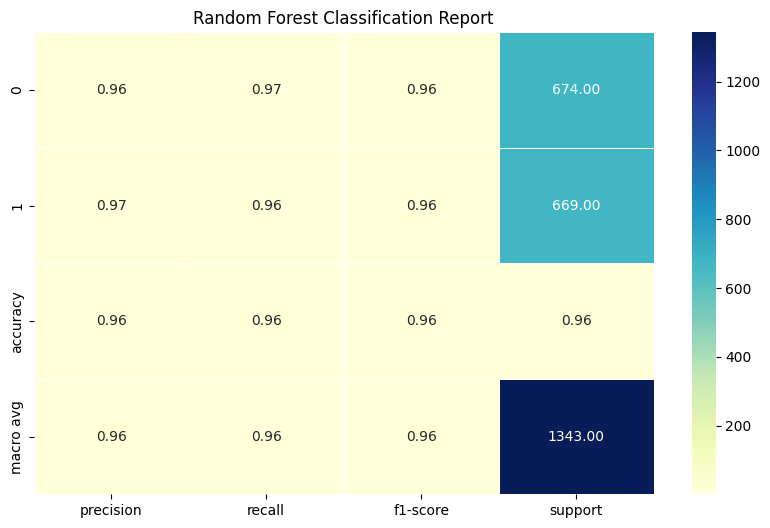

In [369]:
plt.figure(figsize=(10,6))
sns.heatmap(df_report.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("Random Forest Classification Report")
plt.show()

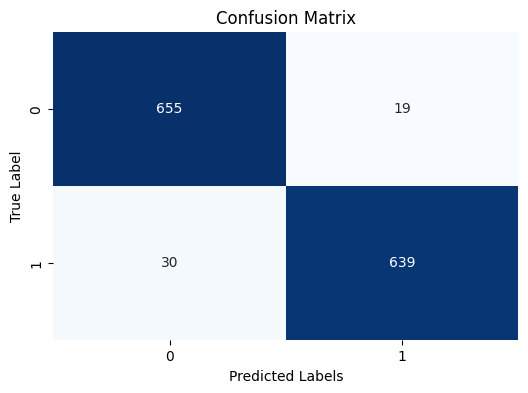

In [370]:
# Evaluate the model using Confusion Matrix 
conf_mat = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [371]:
accuracy1= accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy1:.2f}\n")

Accuracy: 0.96



# Second Model Logistic Regreesion 

In [372]:
# Train model 
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression()

In [373]:
# Make prediction 
y_pred = model2.predict(X_test)

In [374]:
report2 = classification_report(y_test, y_pred, output_dict=True)

In [375]:
df_report2 = pd.DataFrame(report2).transpose()

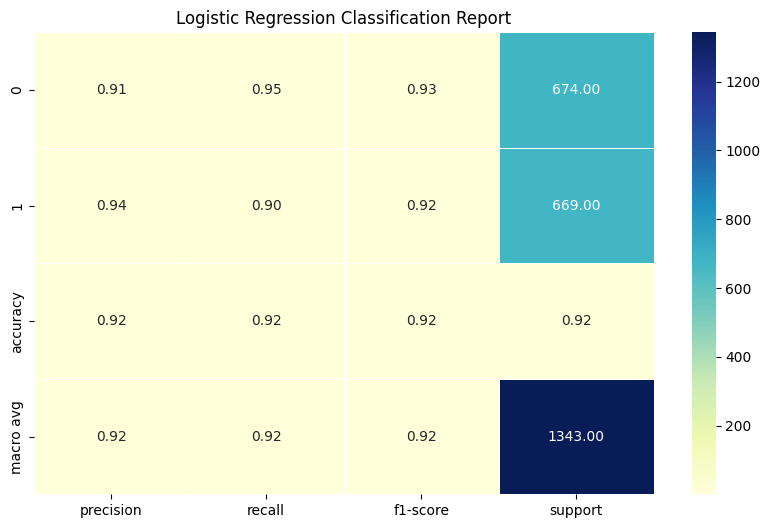

In [376]:
plt.figure(figsize=(10,6))
sns.heatmap(df_report2.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu", fmt=".2f", linewidths=.5)
plt.title("Logistic Regression Classification Report")
plt.show()

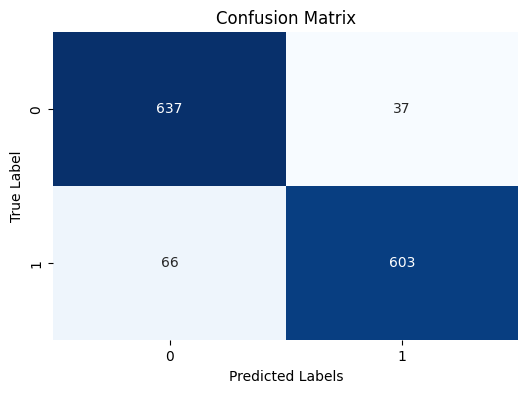

In [377]:
# Evaluate the model using Confusion Matrix 
conf_mat = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [378]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

Accuracy: 0.92

